# Install and Import Necessary Libraries

In [ ]:
!pip install seaborn
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 60.1 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
import joblib
import mne

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import matthews_corrcoef, roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix
from scipy.stats import pearsonr
from scipy.fft import fft
from tabulate import tabulate

import tensorflow as tf
tf.random.set_seed(42)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, GlobalMaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam, RMSprop, AdamW, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import ELU, ReLU

from tensorflow import keras
print(tf.version.VERSION)

#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

2.17.0
Mounted at /content/drive


In [ ]:
def set_seed(seed: int = 42) -> None:

  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  tf.experimental.numpy.random.seed(seed)
  # When running on the CuDNN backend, two further options must be set
  os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
  os.environ['TF_DETERMINISTIC_OPS'] = '1'
  # Set a fixed value for the hash seed
  os.environ["PYTHONHASHSEED"] = str(seed)
  print(f"Random seed set as {seed}")

set_seed(42) #attach weights and biases citation

#https://wandb.ai/sauravmaheshkar/RSNA-MICCAI/reports/How-to-Set-Random-Seeds-in-PyTorch-and-Tensorflow--VmlldzoxMDA2MDQy

Random seed set as 42


# Directories (Local and Google Drive)

In [ ]:
#local Drive

#seg_dir = r'C://Users//123100025//Downloads//h_seg_data' #segmented EEG files
#seg_label_dir = r'C://Users//123100025//Downloads//h_seg_data/segment_labels' #EEG labels

#google drive
seg_dir = '/content/drive/MyDrive/h_seg_data' #segmented EEG files
seg_label_dir = '/content/drive/MyDrive/h_seg_data/segment_labels' #EEG labels

# Load The Data

In [ ]:
#initialize lists to store the loaded files
eeg_segments = []
eeg_labels = []

#check if the segment directory exists
if os.path.exists(seg_dir):

    #list the files/folders within the directory
    files = os.listdir(seg_dir)
    print(f"The folder consists of the following files:\n{files}")

    #for each patient ID from 1 to 79
    for p_id in range(1, 80):

        #define the paths for patient wise EEG segments and labels
        segment_fpath = os.path.join(seg_dir, f'eeg{p_id}_segments.npy')
        label_fpath = os.path.join(seg_label_dir, f'eeg{p_id}_labels.npy')

        #check if the segment and label files for that patient ID exist in their respective paths
        if os.path.exists(segment_fpath) and os.path.exists(label_fpath):

            #load the segments and labels
            segment = np.load(segment_fpath)
            label = np.load(label_fpath)

            #add it to their corresponding lists
            eeg_segments.append(segment)
            eeg_labels.append(label)

        #if the file for that patient ID doesn't exist
        else:

            print(f"Patient file {p_id} missing.")

    #stack the 3D arrays vertically
    eeg_segments = np.vstack(eeg_segments)
    #combine all the labels one after another
    eeg_labels = np.concatenate(eeg_labels, axis = 0)

    #transpose the array to the shape [samples, time steps, channels]
    eeg_Tsegments = np.transpose(eeg_segments, (0, 2, 1))

    print(f'Original EEG Segments shape: {eeg_segments.shape}')
    print(f'Transposed EEG Segments shape: {eeg_Tsegments.shape}')

else:

    print("Directory doesn't exist.")

The folder consists of the following files:
['eeg2_segments.npy', 'eeg1_segments.npy', 'eeg4_segments.npy', 'eeg3_segments.npy', 'eeg5_segments.npy', 'eeg6_segments.npy', 'eeg7_segments.npy', 'eeg8_segments.npy', 'eeg9_segments.npy', 'eeg10_segments.npy', 'eeg11_segments.npy', 'eeg12_segments.npy', 'eeg13_segments.npy', 'eeg14_segments.npy', 'eeg15_segments.npy', 'eeg16_segments.npy', 'eeg18_segments.npy', 'eeg17_segments.npy', 'eeg20_segments.npy', 'eeg19_segments.npy', 'eeg21_segments.npy', 'eeg23_segments.npy', 'eeg22_segments.npy', 'eeg24_segments.npy', 'eeg26_segments.npy', 'eeg25_segments.npy', 'eeg27_segments.npy', 'eeg28_segments.npy', 'eeg29_segments.npy', 'eeg30_segments.npy', 'eeg31_segments.npy', 'eeg33_segments.npy', 'eeg32_segments.npy', 'eeg34_segments.npy', 'eeg36_segments.npy', 'eeg35_segments.npy', 'eeg37_segments.npy', 'eeg38_segments.npy', 'eeg39_segments.npy', 'eeg40_segments.npy', 'eeg41_segments.npy', 'eeg42_segments.npy', 'eeg43_segments.npy', 'eeg44_segments.np

# Split The Data


In [ ]:
#split data into training (80%) and test (20%) sets
train_seg, test_seg, train_labels, test_labels = train_test_split(eeg_Tsegments,
                                                                  eeg_labels,
                                                                  test_size=0.2,
                                                                  random_state=42,
                                                                  stratify=eeg_labels)

#split the training data into 70% train and 10% validation
x_train, val_seg, y_train, val_labels = train_test_split(train_seg,
                                                         train_labels,
                                                         test_size=0.125,
                                                         random_state=42,
                                                         stratify=train_labels)

#split the remaining training set into 20% labelled set (x_train_lseg) and 50% unlabelled set
#(assume for pseudo labelling process) (x_train_unseg)
x_train_lseg, x_train_unseg, y_train_labels, y_train_unlabels = train_test_split(x_train,
                                                                                 y_train,
                                                                                 test_size=0.715,
                                                                                 random_state=42,
                                                                                 stratify=y_train)

print(f'\nEntire data shape: {eeg_Tsegments.shape}') #100% data
print(f'\nEntire Labels Shape: {eeg_labels.shape}')

print(f'Training Data Shape: {x_train.shape}') #70% train
print(f'Training Labels Shape: {y_train.shape}')

print(f"Test data shape: {test_seg.shape}") #20% test
print(f"Test labels shape: {test_labels.shape}")

print(f'Validation Data Shape: {val_seg.shape}') #10% validation during training
print(f'Validation Labels Shape: {val_labels.shape}')

print(f"\nLabelled training data shape: {x_train_lseg.shape}") #20% labelled training set
print(f"\nLabelled training labels shape: {y_train_labels.shape}")

print(f"Unlabelled training data shape: {x_train_unseg.shape}") #50% unlabelled training set
print(f"Unlabelled training labels shape: {y_train_unlabels.shape}")


Entire data shape: (100441, 1024, 18)

Entire Labels Shape: (100441,)
Training Data Shape: (70308, 1024, 18)
Training Labels Shape: (70308,)
Test data shape: (20089, 1024, 18)
Test labels shape: (20089,)
Validation Data Shape: (10044, 1024, 18)
Validation Labels Shape: (10044,)

Labelled training data shape: (20037, 1024, 18)

Labelled training labels shape: (20037,)
Unlabelled training data shape: (50271, 1024, 18)
Unlabelled training labels shape: (50271,)


Class Distribution of the Entire Dataset: Counter({0: 87650, 1: 12791})
Total Number of Data Samples = 100441
Non-seizure class distribution =  87.27%
Seizure class distribution = 12.73%


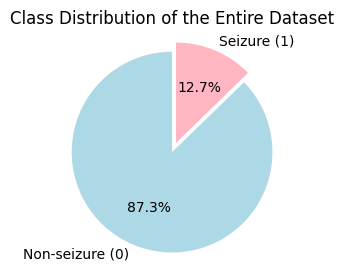

Class Distribution of the Labelled Training Dataset: Counter({0: 17485, 1: 2552})
Total Number of Data Samples = 20037
Non-seizure class distribution =  87.26%
Seizure class distribution = 12.74%


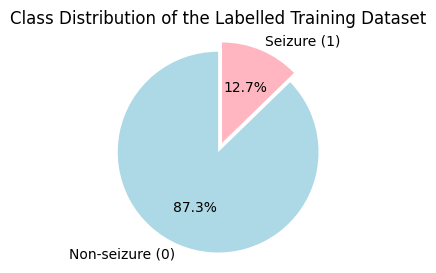

Class Distribution of the Unlabelled Training Dataset: Counter({0: 43869, 1: 6402})
Total Number of Data Samples = 50271
Non-seizure class distribution =  87.27%
Seizure class distribution = 12.73%


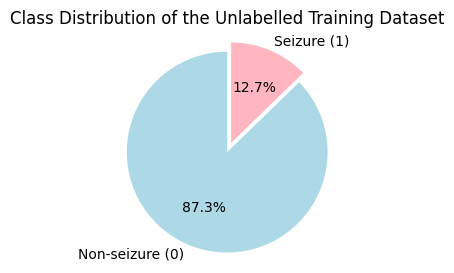

Class Distribution of the Validation Dataset: Counter({0: 8765, 1: 1279})
Total Number of Data Samples = 10044
Non-seizure class distribution =  87.27%
Seizure class distribution = 12.73%


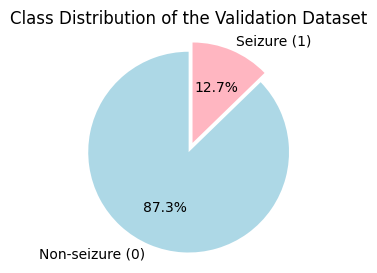

Class Distribution of the Test Dataset: Counter({0: 17531, 1: 2558})
Total Number of Data Samples = 20089
Non-seizure class distribution =  87.27%
Seizure class distribution = 12.73%


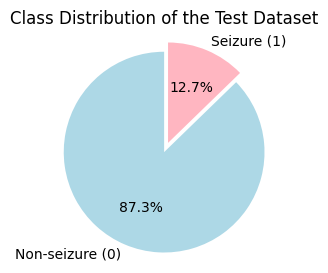

In [ ]:
#function to calculate the class imbalances across the datasets
def data_balance(dataset, name):

    #count the occurences of each class
    samples_counter = Counter(dataset)
    print(f'Class Distribution of the {name}: {samples_counter}')

    #calculate the distribution
    total_samples = len(dataset)
    class_0 = (samples_counter[0] / total_samples) * 100 #nonseizure
    class_1 = (samples_counter[1] / total_samples) * 100 #seizure

    print(f'Total Number of Data Samples = {total_samples}')
    print(f'Non-seizure class distribution =  {class_0:.2f}%')
    print(f'Seizure class distribution = {class_1:.2f}%')

    #plot the distribution
    labels = ['Non-seizure (0)', 'Seizure (1)']
    sizes = [class_0, class_1]
    colors = ['lightblue', 'lightpink']
    explode = (0, 0.1)

    plt.figure(figsize=(3,3))

    plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.axis('equal') #circle
    plt.title(f'Class Distribution of the {name}')
    plt.show()

data_balance(eeg_labels, "Entire Dataset")
data_balance(y_train_labels, "Labelled Training Dataset")
data_balance(y_train_unlabels, "Unlabelled Training Dataset")
data_balance(val_labels, "Validation Dataset")
data_balance(test_labels, "Test Dataset")

# Ideal Model and Base Model

## Build The Model

In [ ]:
#define the 1D CNN model
def CNN_1D(input_shape):

    model = Sequential()

    #layer 1
    model.add(Conv1D(filters=32, kernel_size=3, strides=1, activation='relu', input_shape=input_shape))

    #layer2
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

    #layer3
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())

    #layer4
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())

    #layer5
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())

    model.add(GlobalMaxPooling1D())

    model.add(Flatten())

    #dense layer1
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))

    #dense layer2
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))

    #output dense layer
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    return model

input_shape = (x_train_lseg.shape[1], x_train_lseg.shape[2])
model = CNN_1D(input_shape)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)                    │ (None, 1022, 32)            │           1,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ (None, 1020, 32)            │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 1018, 32)            │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 1018, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ (None, 1016, 64)            │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 1016, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_9 (Conv1D)                    │ (None, 1014, 64)            │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 1014, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,793 (116.38 KB)

 Trainable params: 29,473 (115.13 KB)

 Non-trainable params: 320 (1.25 KB)

## Train and Save The Model

### Ideal Model

Epoch 1/30
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 35s 10ms/step - accuracy: 0.5785 - loss: 0.7181 - val_accuracy: 0.8892 - val_loss: 0.3612
Epoch 2/30
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.7923 - loss: 0.4832 - val_accuracy: 0.9039 - val_loss: 0.2788
Epoch 3/30
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.8385 - loss: 0.4133 - val_accuracy: 0.9273 - val_loss: 0.2204
Epoch 4/30
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.8524 - loss: 0.3864 - val_accuracy: 0.9176 - val_loss: 0.2437
Epoch 5/30
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.8647 - loss: 0.3550 - val_accuracy: 0.9275 - val_loss: 0.2105
Epoch 6/30
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.8726 - loss: 0.3319 - val_accuracy: 0.9120 - val_loss: 0.2163
Epoch 7/30
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.8767 - loss: 0.3235 - val_accuracy: 0.9329 - val_loss: 0.1998
Epoch 8/30
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.8812 - loss: 

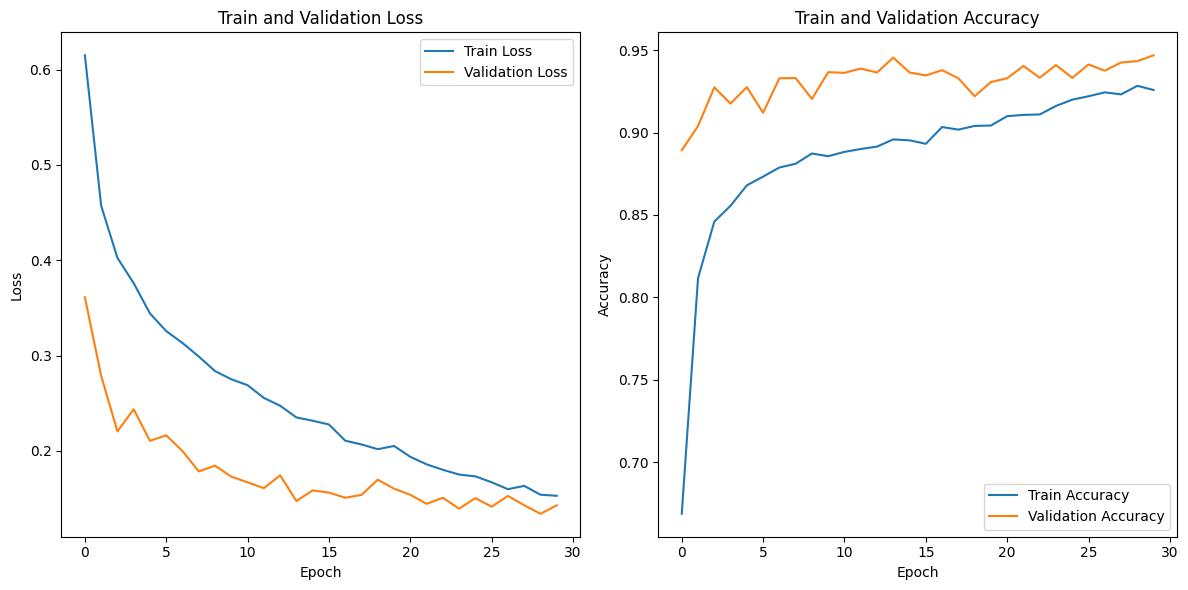

In [ ]:
input_shape = (x_train.shape[1], x_train.shape[2])
ideal_model = CNN_1D(input_shape)

#calculate class weights for the labelled training set
class_weights = class_weight.compute_class_weight(
    class_weight = 'balanced',
    classes= np.unique(y_train_labels),
    y = y_train_labels
)

#cw_dict = dict(enumerate(class_weights))
cw_dict = {0: class_weights[0], 1: class_weights[1]}

#train the model with the class weights
history = ideal_model.fit(x_train,
                         y_train,
                         epochs = 30,
                         batch_size = 32,
                         validation_data = (val_seg, val_labels),
                         class_weight = cw_dict,
                         callbacks=[tensorboard_callback]) #weighted loss function to give importance to the seizure class

#extract history data
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

#plot Loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()

#plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.savefig('ideal_plot.png') #saves both plots together as one figure

plt.tight_layout()
plt.show()

#save the base model
ideal_model.save('ideal_model.h5')

### Base Model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
627/627 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.5141 - loss: 0.7442 - val_accuracy: 0.4954 - val_loss: 0.6660
Epoch 2/30
627/627 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6283 - loss: 0.6337 - val_accuracy: 0.6641 - val_loss: 0.6226
Epoch 3/30
627/627 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7446 - loss: 0.5636 - val_accuracy: 0.8473 - val_loss: 0.4702
Epoch 4/30
627/627 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7940 - loss: 0.4931 - val_accuracy: 0.7629 - val_loss: 0.5238
Epoch 5/30
627/627 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8161 - loss: 0.4561 - val_accuracy: 0.7017 - val_loss: 0.5639
Epoch 6/30
627/627 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8284 - loss: 0.4162 - val_accuracy: 0.8910 - val_loss: 0.3158
Epoch 7/30
627/627 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8339 - loss: 0.4027 - val_accuracy: 0.8628 - val_loss: 0.3568
Epoch 8/30
627/627 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8399 - loss: 0.3782 - val_accuracy: 

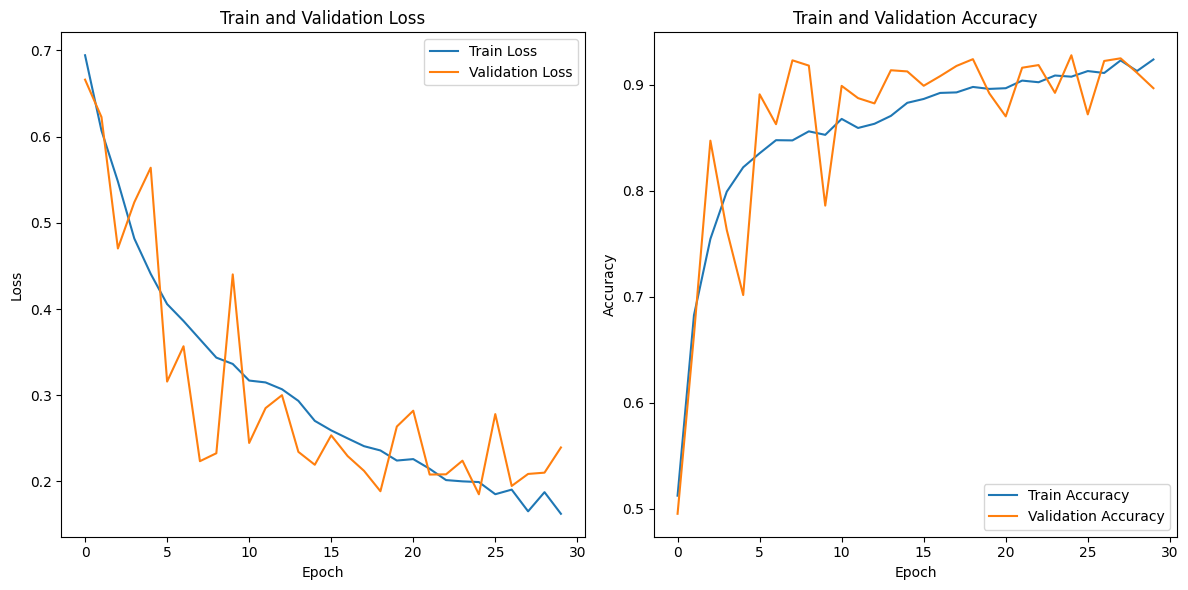

In [ ]:
input_shape = (x_train_lseg.shape[1], x_train_lseg.shape[2])
base_model = CNN_1D(input_shape)

#calculate class weights for the labelled training set
class_weights = class_weight.compute_class_weight(
    class_weight = 'balanced',
    classes= np.unique(y_train_labels),
    y = y_train_labels
)

#cw_dict = dict(enumerate(class_weights))
cw_dict = {0: class_weights[0], 1: class_weights[1]}

#train the model with the class weights
history = base_model.fit(x_train_lseg,
                         y_train_labels,
                         epochs = 30,
                         batch_size = 32,
                         validation_data = (val_seg, val_labels),
                         class_weight = cw_dict) #weighted loss function to give importance to the seizure class

#extract history data
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

#plot Loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()

#plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.savefig('base_plot.png') #saves both plots together as one figure

plt.tight_layout()
plt.show()

#save the base model
base_model.save('base_model.h5')

## Load and Evaluate The Base Model

628/628 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8895 - loss: 0.2637
Test Loss: 0.2545, Test Accuracy: 0.8929
628/628 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
Pearson Correlation Coefficient: 0.6845
Matthews Correlation Coefficient : 0.6181
AUC-ROC: 0.9354


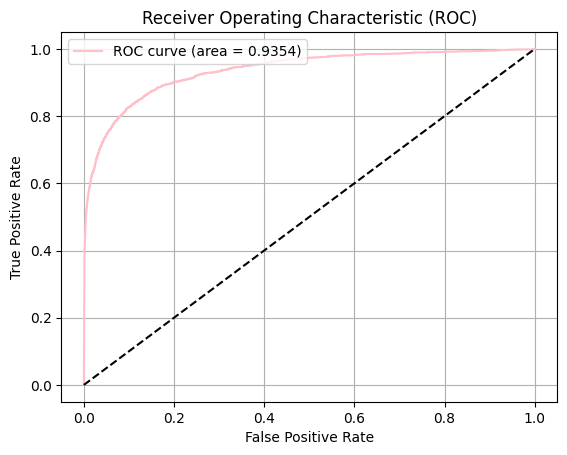

In [ ]:
#load the base model
base_model = tf.keras.models.load_model('base_model.h5')

#evaluate the model
test_loss, test_acc = base_model.evaluate(test_seg, test_labels)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

#predictions and probabilities
test_probs = base_model.predict(test_seg).ravel()
test_preds = (test_probs > 0.5).astype(int)

#Pearson correlation coefficient
pcc = pearsonr(test_probs, test_labels)[0]
print(f"Pearson Correlation Coefficient: {pcc:.4f}")

#Matthews correlation coefficient
mcc = matthews_corrcoef(test_labels, test_preds)
print(f"Matthews Correlation Coefficient : {mcc:.4f}")

#AUC-ROC
auc = roc_auc_score(test_labels, test_probs)
print(f"AUC-ROC: {auc:.4f}")

fpr, tpr, _ = roc_curve(test_labels, test_probs)

#plot ROC Curve
plt.figure()
plt.plot(fpr, tpr,  color='pink', label=f'ROC curve (area = {auc:.4f})')
plt.plot([0,1], [0,1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

## Load and Evaluate The Ideal Model

628/628 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9439 - loss: 0.1573
Test Loss: 0.1505, Test Accuracy: 0.9449%
628/628 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
Pearson Correlation Coefficient: 0.8049
Matthews Correlation Coefficient : 0.7555
AUC-ROC: 0.9693


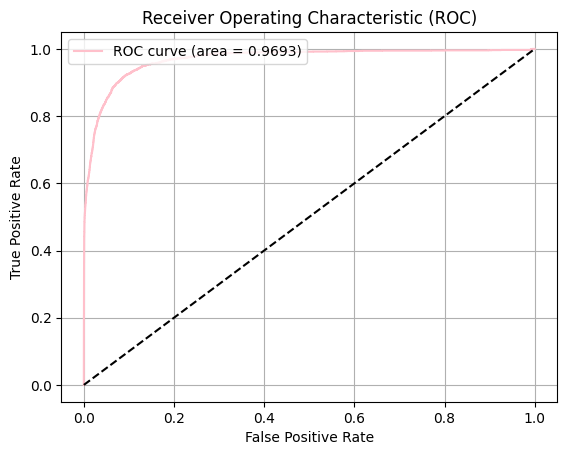

In [ ]:
#load the base model
ideal_model = tf.keras.models.load_model('ideal_model.h5')

# Evaluate the model
test_loss, test_acc = ideal_model.evaluate(test_seg, test_labels)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}%")

#predictions and probabilities
test_probs = ideal_model.predict(test_seg).ravel()
test_preds = (test_probs > 0.5).astype(int)

#Pearson correlation coefficient
pcc = pearsonr(test_probs, test_labels)[0]
print(f"Pearson Correlation Coefficient: {pcc:.4f}")

#Matthews correlation coefficient
mcc = matthews_corrcoef(test_labels, test_preds)
print(f"Matthews Correlation Coefficient : {mcc:.4f}")

#AUC-ROC
auc = roc_auc_score(test_labels, test_probs)
print(f"AUC-ROC: {auc:.4f}")

fpr, tpr, _ = roc_curve(test_labels, test_probs)

#plot ROC Curve
plt.figure()
plt.plot(fpr, tpr,  color='pink', label=f'ROC curve (area = {auc:.4f})')
plt.plot([0,1], [0,1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()